In [1]:
#!/usr/bin/env python3
# coding: utf-8

# Load dependencies
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

# Optimization
import cvxpy as cp

# For more information about cvxpy: https://www.cvxpy.org/examples/
# Model fitting example: https://colab.research.google.com/github/cvxgrp/cvx_short_course/blob/master/applications/model_fitting.ipynb
# Book on convex optimization: https://web.stanford.edu/~boyd/cvxbook/
# Course on optimization: https://web.stanford.edu/class/ee364a/

# Load the data from the Varennes NetZEB Library
Column descriptions:

    # Temperatures
    'T_ext': exterior temp, C
    'T_int': average interior temp, C
    'T_slab: slab temperature, 2 inch from surface, C
    'T_room_air_over_slab': average room temperature over the slab where there is a radiant system, C
    'T_room_air_no_slab': same but where there isn't, C

    # BIPV/T System
    'BIPVT_outletT': temperature at BIPV/T outlet, C
    'BIPVT_dT': ^ minus T_ext, K
    'BIPVT_heat: m*cp*dT = fanstate*rated_flow*density*cp*dT, kW

    # Heating/Cooling
    'geo_heat': m*cp*dT at the geothermal well inlet: how much heat are we rejecting/extracting into the ground, kW
    'heating_total': m*cp*dT at the heat pump condensor/hot side, kW
    'cooling_total': evaporator/cold side, kW
    'Q_slab': heat going into the radiant slab, kW
    'Q_rest_heating': heat going into the air, kW
    'Q_rest': heat - cooling going into the air, kW
    'heating_slab_ratio': heating going into slab over total, rest goes into the air
    'cooling_slab_ratio': cooling going into slab over total, rest goes into the air

    # Windows
    'window_state: 0: closed, 1: open

    # Solar
    'DNI': direct normal irradiance, kW/m^2
    'GHI': global horizontal irradiance, kW/m^2
    'DHI': diffuse horizontal irradiance, kW/m^2
    'solar_projected_PV': unitized solar radiation incident on PV system, kW/m^2

    # Electrical
    'cons': total electrical consumption power, kW
    'prod: total electrical production power, kW
    'cons_noHVAC': approximate electrical consumption without the HVAC (cons - heating_total/4 - cooling_total/3.5), kW

In [19]:
# Load data from csv file, assign index and assure it's a datetime object
df_full = pd.read_csv("data_varennes_subset.csv.zip", index_col=[0], parse_dates=[0])
print(df_full.head())

                       T_ext    T_int  BIPVT_outletT  BIPVT_dT  BIPVT_heat  \
Datetime                                                                     
2018-01-01 00:00:00 -21.8566  18.4578       -18.6184    3.2382         0.0   
2018-01-01 00:15:00 -21.8434  18.4086       -18.6614    3.1820         0.0   
2018-01-01 00:30:00 -21.9561  18.3142       -18.6459    3.3102         0.0   
2018-01-01 00:45:00 -22.0408  18.2528       -18.7473    3.2935         0.0   
2018-01-01 01:00:00 -22.1299  18.1697       -18.6353    3.4946         0.0   

                      geo_heat  heating_total  cooling_total  window_state  \
Datetime                                                                     
2018-01-01 00:00:00 -54.118034      38.025668            0.0      0.335996   
2018-01-01 00:15:00 -50.619191      26.322083            0.0      0.336057   
2018-01-01 00:30:00  -9.066210      13.017722            0.0      0.336118   
2018-01-01 00:45:00 -37.896533      10.618306            0.0   

# Approach
This is an example for 1 iteration. In application, you would optimize for a window of time (called the prediction horizon), only apply the controls within a much smaller window of time (called the control horizon and it could be as small as a single timestep), and redo the optimization all over again. It's not particularly difficult to do that and CVXPY documentation does provide more thorough examples.

I'm also assuming electricity is billed at a unit rate. If you want to use the actual $\$/kWh$ amounts, you have to consider the step size.

I demo two cases: (1) minimize the energy, and (2) minimize the power.

In [103]:
# 2018-01-16: Tuesday
df = df_full["2018-01-17 0:00":"2018-01-17 12:00"].copy()

# Define our dependent/independent variables
X_cols = ["T_int"]  # state_columns
U_cols = ["heating_total"]  # control_columns
W_cols = ["T_ext", "GHI"]  # exogenous_columns

# TEST
X = df[X_cols].values
U = df[U_cols].iloc[:-1].values
W = df[W_cols].iloc[:-1].values

X_initial = X[0, np.newaxis]

In [104]:
# Business hours
df["is_occupied"] = (9. <= df.index.hour) & (df.index.hour < 18)

# Setpoints when occupied/unoccupied
heating_SP_unoccupied = 18.
heating_SP_occupied = 21.
df["heating_SP"] = heating_SP_unoccupied
# Update for occupied setpoint
df.loc[df["is_occupied"], "heating_SP"] = heating_SP_occupied

# Equipment size, puting it in the dataframe since this is more flexible 
# if you want to have a different capacity depending on the time of day
df["heating_power_min"] = 0.  # kW
df["heating_power_max"] = 100.  # kW


# df -> numpy
heating_SP = df["heating_SP"].values[:,np.newaxis]  # add new axis otherwise pandas is lazy and drops the extra dimension
heating_power_min = df["heating_power_min"].values[:-1,np.newaxis]
heating_power_max = df["heating_power_max"].values[:-1,np.newaxis]

In [117]:
def build_ABC_model_5(params):
    # Place parameters in A, B, C matrices
    A = np.array([[1 - params["alpha"]]])
    B = np.array([[params["beta"]]])
    C = np.array([[params["alpha"], params["gamma"]]])
    return A, B, C


def run_mpc_step(
    params, 
    X_initial, 
    U, 
    W,
    build_ABC, 
    heating_SP, 
    heating_power_min, 
    heating_power_max,
    objective_fn = 'energy'
):
    """ Run an MPC step. """
    # Build A, B, C matrices and get their dimensions
    A, B, C = build_ABC(params)
    nN, nM, nL = A.shape[1], B.shape[1], C.shape[1]

    # Prediction horizon, assume same length as U
    ph = len(U)

    # Declare Variables
    x = cp.Variable((ph+1, nN))
    u = cp.Variable((ph, nM))
    # we have no control over W, for the MPC run, it's a constant


    # Constraints to be accumulated
    constraints = []

    # Initial Condition
    constraints.append(x[0,] == X_initial)

    # Dynamics
    for t in range(ph): 
        constraints.append(x[t+1,] == A @ x[t,].T + B @ u[t,].T + C @ W[t,].T,)

    # Comfort
    constraints.append(x >= heating_SP)  # NOTE: these are vectors

    # Constraint size of equipment
    constraints.append(u >= heating_power_min)  # NOTE: these are vectors
    constraints.append(u <= heating_power_max)  # NOTE: these are vectors


    # Objective function
    if objective_fn == 'energy':
        # Option 1: minimize sum of energy (didn't put the timestep since it has no effect on the optimal solution)
        objective = cp.Minimize(cp.sum(u))
    elif objective_fn == 'power':
        # Option 2: minimize peak use of energy using a norm-2 loss
        objective = cp.Minimize(cp.norm2(u))
    else:
        # Unknown objective!
        raise NotImplementedError("Either select `energy` or `power` for the objective function!")

    # Solve
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.ECOS, verbose=True)

    return problem, x, u

In [118]:
# Parameters from previous notebook
params = {
    "alpha": 0.00053596,
    "beta": 0.0012117,  # had to modify beta a bit :S
    # "beta": 0.00012117,
    "gamma": 0.30312252
}

# Additional information needed to describe the problem
mpc_kwargs = {
    "X_initial": X_initial,
    "U": U,
    "W": W,
    "build_ABC": build_ABC_model_5,  # pass the ABC generator
    "heating_SP": heating_SP,
    "heating_power_min": heating_power_min,
    "heating_power_max": heating_power_max,
}

---
### Minimize Energy


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.399e+03  -3.420e+03  +7e+03  8e-05  4e-01  1e+00  5e+01    ---    ---    1  1  - |  -  - 
 1  +1.881e+03  -1.940e+03  +5e+03  5e-05  3e-02  1e+00  3e+01  0.3557  4e-02   1  0  0 |  0  0
 2  +1.990e+03  -1.835e+03  +5e+03  5e-05  6e-03  2e+00  3e+01  0.0067  1e+00   1  0  1 |  0  0
 3  +1.784e+03  +2.998e+02  +2e+03  2e-05  4e-04  9e+00  1e+01  0.8889  3e-01   1  0  0 |  0  0
 4  +1.429e+03  +1.360e+03  +9e+01  9e-07  2e-05  4e-01  6e-01  0.9564  3e-03   1  0  0 |  0  0
 5  +1.422e+03  +1.377e+03  +6e+01  6e-07  1e-05  3e-01  4e-01  0.4007  1e-01   1  0  0 |  0  0
 6  +1.413e+03  +1.398e+03  +2e+01  2e-07  5e-06  1e-01  1e-01  0.7005  7e-02   1  0  0 |  0  0
 7  +1.410e+03  +1.406e+03  +5e+00  5e-08  1e-06  3e-02  4e-02  0.7543  2e-02   1  0  0 |  0  0
 8  +1.409e+03  +1.407e+03  +2e+00  2e-08  4e-

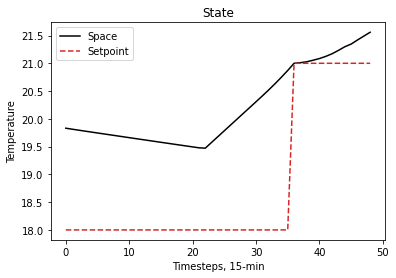

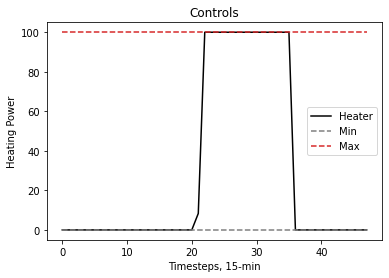

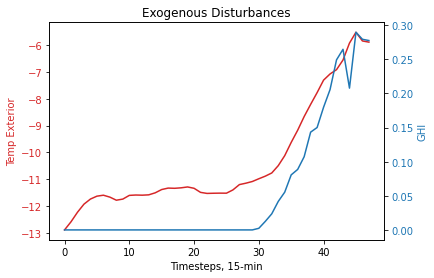

In [119]:
# Run the optimization to minimize ENERGY
opti_problem, opti_x, opti_u = run_mpc_step(params, **mpc_kwargs, objective_fn='energy')  # the double ** unrolls the dictionary

# Plot results
# X: State
x_val = np.arange(len(opti_x.value))
plt.plot(x_val, opti_x.value, c="black", label="Space")
plt.plot(x_val, heating_SP, c="tab:red", linestyle="--", label="Setpoint")
plt.xlabel("Timesteps, 15-min")
plt.ylabel("Temperature")
plt.title("State")
plt.legend()
plt.show()

# U: Controls
plt.plot(x_val[:-1], opti_u.value, c="black", label="Heater")
plt.plot(x_val[:-1], heating_power_min, c="tab:grey", linestyle="--", label="Min")
plt.plot(x_val[:-1], heating_power_max, c="tab:red", linestyle="--", label="Max")
plt.xlabel("Timesteps, 15-min")
plt.ylabel("Heating Power")
plt.title("Controls")
plt.legend()
plt.show()

# W: Exogenous inputs, measurable disturbances
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Timesteps, 15-min')
ax1.set_ylabel('Temp Exterior', color=color)
ax1.plot(x_val[:-1], W[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('GHI', color=color)  # we already handled the x-label with ax1
ax2.plot(x_val[:-1], W[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Exogenous Disturbances")
plt.show()

---
### Minimize Power


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.879e+03  +7e+03  9e-02  2e-01  1e+00  5e+01    ---    ---    1  1  - |  -  - 
 1  +2.899e+02  -4.244e+02  +2e+03  2e-02  5e-03  9e+00  1e+01  0.9890  2e-01   1  1  1 |  0  0
 2  +1.510e+02  -8.408e+01  +5e+02  6e-03  2e-03  3e+00  4e+00  0.6661  2e-02   1  1  1 |  0  0
 3  +1.862e+02  -6.103e+01  +5e+02  6e-03  1e-03  3e+00  4e+00  0.0509  9e-01   1  1  1 |  0  0
 4  +2.402e+02  +1.344e+02  +2e+02  3e-03  2e-04  2e+00  1e+00  0.7893  2e-01   1  1  1 |  0  0
 5  +2.386e+02  +1.405e+02  +2e+02  3e-03  2e-04  1e+00  1e+00  0.3257  8e-01   1  1  1 |  0  0
 6  +2.332e+02  +2.196e+02  +3e+01  3e-04  3e-05  2e-01  2e-01  0.9147  6e-02   1  1  1 |  0  0
 7  +2.349e+02  +2.310e+02  +7e+00  1e-04  7e-06  5e-02  5e-02  0.8639  2e-01   1  1  1 |  0  0
 8  +2.356e+02  +2.338e+02  +3e+00  5e-05  3e-

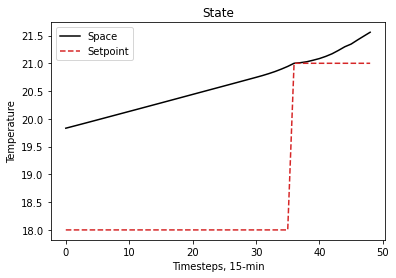

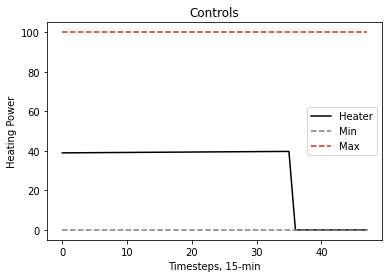

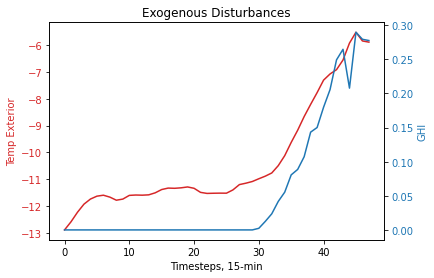

In [120]:
# Run the optimization to minimize POWER
opti_problem, opti_x, opti_u = run_mpc_step(params, **mpc_kwargs, objective_fn='power')  # the double ** unrolls the dictionary

# Plot results
# X: State
x_val = np.arange(len(opti_x.value))
plt.plot(x_val, opti_x.value, c="black", label="Space")
plt.plot(x_val, heating_SP, c="tab:red", linestyle="--", label="Setpoint")
plt.xlabel("Timesteps, 15-min")
plt.ylabel("Temperature")
plt.title("State")
plt.legend()
plt.show()

# U: Controls
plt.plot(x_val[:-1], opti_u.value, c="black", label="Heater")
plt.plot(x_val[:-1], heating_power_min, c="tab:grey", linestyle="--", label="Min")
plt.plot(x_val[:-1], heating_power_max, c="tab:red", linestyle="--", label="Max")
plt.xlabel("Timesteps, 15-min")
plt.ylabel("Heating Power")
plt.title("Controls")
plt.legend()
plt.show()

# W: Exogenous inputs, measurable disturbances
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Timesteps, 15-min')
ax1.set_ylabel('Temp Exterior', color=color)
ax1.plot(x_val[:-1], W[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('GHI', color=color)  # we already handled the x-label with ax1
ax2.plot(x_val[:-1], W[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Exogenous Disturbances")
plt.show()

## Conclusion
+ Notice the difference between running it to minimize energy vs power? How did the controls change? And the temperature?
+ Change the start time and see what happens by modifying the range in this `df = df_full["2018-01-17 0:00":"2018-01-17 12:00"].copy()` above.
+ Override the initial temperature.
+ Change the maximum value for the heater.
+ Change the values for $\alpha$, $\beta$ and $\gamma$. How does it change the behaviour?
+ Try blending both cases to minimize a combination of energy and power.